# Testing the haversine loss function

I have three goals:
- Verify that the haversine loss function is differentiable by running a simple case in TensorFlow.
- Understand the relative utility of the mean distance error versus the mean squared distance error.
- Explore learning rates.

To do this, I'm going to explore a very simple problem.
- $X$ is a series of geocoordinates.
- $y$ are geocoordinates perturbed five miles north of $X$ so that $y_{lat} = X_{lat} + 5$ and $y_{long} = X_{long}$.

The model is a MLP with 10 hidden nodes in a single layer.

## Candidate functions

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def haversine_sq_loss(y_true, y_pred, R=3443.92):
    """
    Returns the mean squared haversine distance
    between arrays consisting of lattitudes and
    longitudes.
    
    Args:
        y_true:  Either an np.array or a tf.constant
                 of dimensions m x 2 where m in the
                 number of observations.  Each row is
                 an ordered pair of [lat, long].
                 
        y_pred:  Has the same form as y_true.
        
        R:       Float giving the radius of the earth.
                 The default value is in nautical
                 miles.  Values in other units:
                 
                 kilometers    -> 6378.14
                 statute miles -> 3963.19
                 smoots        -> 3.748e+6
        
    Returns:
        tf.tensor of shape () and dtype float64 giving
        the mean square distance error using the
        haversine function.
    
    Examples:
    
        Input:
        y1     = np.array([[0, 0]])
        y_hat1 = np.array([[0, 180]])
        
        Expected result:
        (pi * R) ** 2 = 117059281.6 nm^2
        
        Input:
        y2     = np.array([[0, 0]])
        y_hat2 = np.array([[90, 0]])
        
        Expected result:
        (pi * R / 2) ** 2 = 29264820.4 nm^2
        
        Input:
        Portmsouth, VA to Rota, Spain
        y3     = tf.constant([[36.8354, -76.2983]])
        y_hat3 = tf.constant([[36.6237, -6.3601]])
        
        Expected result:
        37065212.0 km^2
        
    Notes:
        Closely follows the JS implmentation at
        https://www.movable-type.co.uk/scripts/latlong.html.
    """
    # Break inputs into lattitudes and longitudes for
    # convienience
    lat1  = y_true[:,0]
    lat2  = y_pred[:,0]
    long1 = y_true[:,1]
    long2 = y_pred[:,1]
    
    # Compute phis and lambdas 
    phi1 = lat1 * np.pi / 180
    phi2 = lat2 * np.pi / 180
    delta_phi    = (lat2 - lat1) * np.pi / 180
    delta_lambda = (long2 - long1) * np.pi / 180
    
    # Intermediate computations
    a = tf.square(tf.sin(delta_phi / 2)) + tf.cos(phi1) * tf.cos(phi2) * tf.square(tf.sin(delta_lambda / 2))
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    
    # Compute distances
    d = R * c
    
    # Compute the mean squared distance (MSE)
    return tf.reduce_mean(tf.square(d))

In [3]:
def haversine_loss(y_true, y_pred, R=3443.92):
    """
    Returns the mean squared haversine distance
    between arrays consisting of lattitudes and
    longitudes.
    
    Args:
        y_true:  Either an np.array or a tf.constant
                 of dimensions m x 2 where m in the
                 number of observations.  Each row is
                 an ordered pair of [lat, long].
                 
        y_pred:  Has the same form as y_true.
        
        R:       Float giving the radius of the earth.
                 The default value is in nautical
                 miles.  Values in other units:
                 
                 kilometers    -> 6378.14
                 statute miles -> 3963.19
                 smoots        -> 3.748e+6
        
    Returns:
        tf.tensor of shape () and dtype float64 giving
        the mean square distance error using the
        haversine function.
    
    Examples:
    
        Input:
        y1     = np.array([[0, 0]])
        y_hat1 = np.array([[0, 180]])
        
        Expected result:
        (pi * R) ** 2 = 117059281.6 nm^2
        
        Input:
        y2     = np.array([[0, 0]])
        y_hat2 = np.array([[90, 0]])
        
        Expected result:
        (pi * R / 2) ** 2 = 29264820.4 nm^2
        
        Input:
        Portmsouth, VA to Rota, Spain
        y3     = tf.constant([[36.8354, -76.2983]])
        y_hat3 = tf.constant([[36.6237, -6.3601]])
        
        Expected result:
        37065212.0 km^2
        
    Notes:
        Closely follows the JS implmentation at
        https://www.movable-type.co.uk/scripts/latlong.html.
    """
    # Break inputs into lattitudes and longitudes for
    # convienience
    lat1  = y_true[:,0]
    lat2  = y_pred[:,0]
    long1 = y_true[:,1]
    long2 = y_pred[:,1]
    
    # Compute phis and lambdas 
    phi1 = lat1 * np.pi / 180
    phi2 = lat2 * np.pi / 180
    delta_phi    = (lat2 - lat1) * np.pi / 180
    delta_lambda = (long2 - long1) * np.pi / 180
    
    # Intermediate computations
    a = tf.square(tf.sin(delta_phi / 2)) + tf.cos(phi1) * tf.cos(phi2) * tf.square(tf.sin(delta_lambda / 2))
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    
    # Compute distances
    d = R * c
    
    # Compute the mean squared distance (MSE)
    return tf.reduce_mean(d)

## Function to generate data

In [4]:
def generate_synthetic_data(n=2000):
  X = np.random.rand(n, 2)
  X[:,0] = X[:,0] * 170 - 85
  X[:,1] = X[:,1] * 350 - 175
  #print(X[:,0].min(), X[:,0].max())
  #print(X[:,1].min(), X[:,1].max())

  y = X
  y[:,0] = y[:,0] + 3
  #print('\n')
  #print(y[:,0].min(), y[:,0].max())
  #print(y[:,1].min(), y[:,1].max())

  return X, y

## Function to build and test the model

In [5]:
def build_model(loss, lr, n=2000, num_epochs=1000, verbose=0):
  X, y = generate_synthetic_data(n)

  input = tf.keras.layers.Input(shape=2)
  x = tf.keras.layers.Dense(10)(input)
  x = tf.keras.layers.Dense(10)(x)
  output = tf.keras.layers.Dense(2)(x)
  model = tf.keras.Model(inputs=input, outputs=output)

  #model.summary()

  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr))
  
  history = model.fit(X, y, epochs=num_epochs, verbose=verbose)
  return history.history['loss']

In [8]:
results = []

#for loss in [haversine_loss, haversine_sq_loss, 'rmse']:
for loss in [haversine_loss]:
  #for lr in [0.01, 0.001, 0.0001, 0.00001]:
  for lr in [0.0001]:
    #for n in [100, 200, 400, 800, 1600]:
    for n in [800]:
      for i in range(1):
        tf.keras.backend.clear_session()
        print(loss, lr, n)
        results.append(build_model(loss=loss, lr=lr, n=n, num_epochs=1000))

<function haversine_loss at 0x7fd5f8ccde18> 0.0001 800


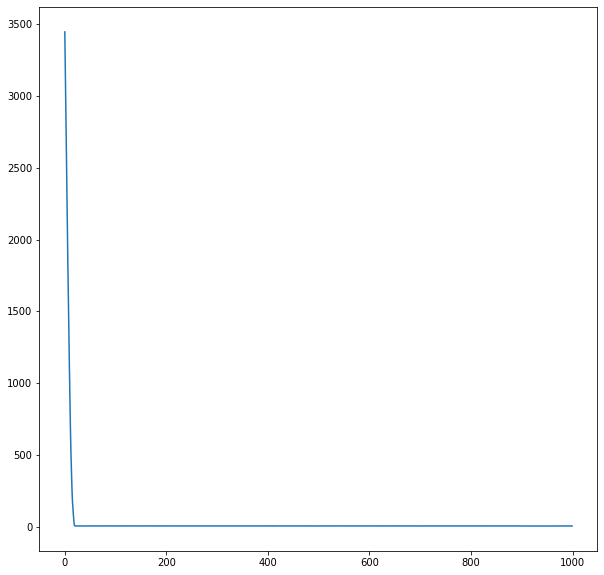

In [10]:
plt.figure(figsize=(10,10))
for result in results:
  plt.plot(np.arange(1000), result)
plt.show()

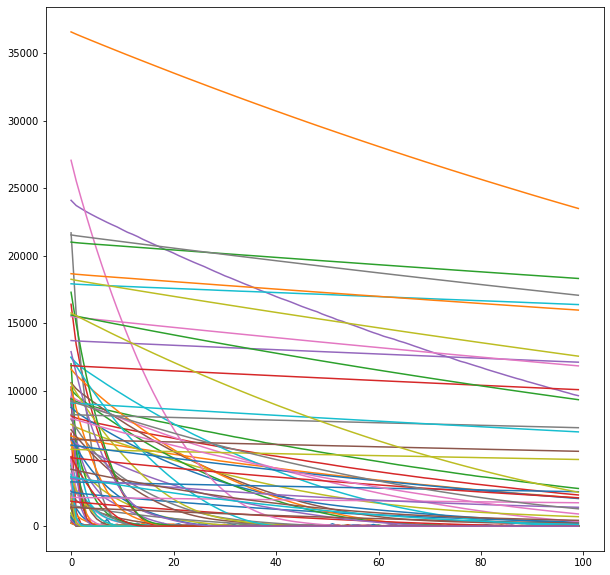

In [ ]:
plt.figure(figsize=(10,10))
for result in results:
  plt.plot(np.arange(100), result)
plt.show()